In [1]:
# Setup code

import sys
sys.path.insert(0, "..")
basedir = "../.."

import datetime
import skdim
import glob
import time
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
import pickle
import re
import os
from sklearn.decomposition import PCA
import ipywidgets as widgets

from torch.utils.data import DataLoader

import models
import utils

def determine_params(paramarr):
  encoding_param = []
  P = paramarr.shape[1]

  for p in range(P):
    if np.abs(paramarr[0, p] - paramarr[1, p]) > 0:
      encoding_param.append(p)

  return encoding_param

%matplotlib widget
plt.rcParams["figure.figsize"] = (7, 4)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

dsets = [(f"{basedir}/datasets/burgers/grfarc2visc0p001-shift.mat", "grfarc2visc0p001"),
          (f"{basedir}/datasets/burgers/grfarc2visc0p001-scale.mat", "grfarc2visc0p001"),
          (f"{basedir}/datasets/transport/hats2_2500_shift.mat", "alldata"),
          (f"{basedir}/datasets/transport/hats2_2500_scale.mat", "alldata"),
          (f"{basedir}/datasets/kdv/kdv2-shift.mat", "kdv2wide"),
          (f"{basedir}/datasets/kdv/kdv2-scale.mat", "kdv2wide")]

names = ["bshift", "bscale", "tshift", "tscale", "kshift", "kscale"]

In [2]:
def create_error_tabledict(errors, labels, transposed=False):
  if transposed:
    num_cols = len(labels)

    table = "\\begin{table}[h]\n\\centering\n"
    table += "\\begin{tabular}{|" + "r|" * (num_cols + 1) + "}\n"
    table += "\\hline\n"
    table += "& " + " & ".join([str(label) for label in labels]) + " \\\\\n\\hline\n"

    for row_name, row_values in errors.items():
        table += row_name + " & " + " & ".join([f"{val*100:.2f}" for val in row_values]) + " \\\\\n\\hline\n"

    table += "\\end{tabular}\n"
    table += "\\end{table}"
    return table
  
  else:
    columns = list(errors.keys())
    num_cols = len(columns)

    table = "\\begin{table}[h]\n\\centering\n"
    table += "\\begin{tabular}{|" + "r|" * (num_cols + 1) + "}\n"
    table += "\\hline\n"
    table += "& " + " & ".join([str(col) for col in columns]) + " \\\\\n\\hline\n"

    for label, col_values in zip(labels, zip(*[errors[col] for col in columns])):
        table += str(label) + " & " + " & ".join([f"{val*100:.2f}" for val in col_values]) + " \\\\\n\\hline\n"

    table += "\\end{tabular}\n"
    table += "\\end{table}"
    return table

def create_error_table(errors, labels):
    num_cols = max(len(row) for row in errors)

    table = "\\begin{table}[h]\n\\centering\n"
    table += "\\begin{tabular}{|" + "r|" * (num_cols + 1) + "}\n"
    table += "\\hline\n"

    table += "& " + " & ".join([str(i + 1) for i in range(num_cols)]) + " \\\\\n\\hline\n"

    for label, row in zip(labels, errors):
        table += str(label) + " & " + " & ".join([f"{val*100:.2f}" for val in row]) + " \\\\\n\\hline\n"

    table += "\\end{tabular}\n"
    table += "\\end{table}"

    return table

In [36]:
baseepochs = 100

aeclass = models.FFAutoencoder
propclass = models.FFNet

welds = {}

start = 0
end = 4

for dset, name in zip(dsets[start:end], names[start:end]):
  dataset = utils.DynamicData(dset)
  print(dset, name)

  dataset.shuffle_inplace()
  dataset.subset_data(500)
  dataset.downsample(int(dataset.data.shape[2] / 256))
  #dataset.data = dataset.data[:, ::2]
  dataset.scaledown()

  din = dataset.data.shape[-1]
  Lae = 3
  Lprop = 3
  pae = 500
  pprop = 300
  rp = True
  trans = False

  welds[name] = []
  for k in [4]:
    for style in ["base", "straight", "kinetic"]:
      for w in [1]:
        for auton in [False]:
          aeargs = { "encodeSeq": [din] + [pae] * Lae + [k], "decodeSeq": [k] + [pae] * Lae + [din], "activation": nn.ReLU() }
          propargs = { "seq": [k if auton else k+1] + [pprop] * Lprop + [k], "activation": nn.ReLU() }
          transargs = { "seq": [k] + [pprop] * Lprop + [k], "activation": nn.ReLU() } if trans else None

          if style == "base":
            weld = models.WeldNet(dataset, w, aeclass, aeargs, propclass, propargs, overlapnum=1, device=device, transcoders=transargs, tensorboard_directory=f"{name}base-{k}-{'auton' if auton else 'nonauton'}", straightness=0, autonomous=auton, residualprop=rp)
          elif style == "straight":
            weld = models.WeldNet(dataset, w, aeclass, aeargs, propclass, propargs, overlapnum=1, device=device, transcoders=transargs, tensorboard_directory=f"{name}straight-{k}-{'auton' if auton else 'nonauton'}", straightness=0.1, autonomous=auton, residualprop=rp)
          else:
            weld = models.WeldNet(dataset, w, aeclass, aeargs, propclass, propargs, overlapnum=1, device=device, transcoders=transargs, tensorboard_directory=f"{name}kinetic-{k}-{'auton' if auton else 'nonauton'}", kinetic=10, autonomous=auton, residualprop=rp)
            
          loadprops = weld.load_all(name)

          if trans:
            loadtrans = weld.load_transcoders(name)
            if not loadtrans:
              weld.train_transcoders(baseepochs * 5, printinterval=baseepochs//2, lr=1e-4, save=True)

          welds[name].append(weld)

      #weld.load_props("re")
    #weld.train_aes(baseepochs, warmstart_epochs=baseepochs//2, printinterval=20, batch=16, save=True, plottb=True, lr=1e-4)

('../../datasets/burgers/grfarc2visc0p001-shift.mat', 'grfarc2visc0p001') bshift
Loading aes and props from autoencoders/weld/props\bshiftbase-4-nonauton1w-props-14-August-2024-20.28.pickle
Loading aes and props from autoencoders/weld/props\bshiftstraight-4-nonauton1w-props-14-August-2024-20.30.pickle
Loading aes and props from autoencoders/weld/props\bshiftkinetic-4-nonauton1w-props-14-August-2024-20.32.pickle
('../../datasets/burgers/grfarc2visc0p001-scale.mat', 'grfarc2visc0p001') bscale
Loading aes and props from autoencoders/weld/props\bscalebase-4-nonauton1w-props-14-August-2024-20.34.pickle
Loading aes and props from autoencoders/weld/props\bscalestraight-4-nonauton1w-props-14-August-2024-20.36.pickle
Loading aes and props from autoencoders/weld/props\bscalekinetic-4-nonauton1w-props-14-August-2024-20.39.pickle
('../../datasets/transport/hats2_2500_shift.mat', 'alldata') tshift
Loading aes and props from autoencoders/weld/props\tshiftbase-4-nonauton1w-props-14-August-2024-20.40.

0 50
Average Relative L2 Error over all times: 0.1852


interactive(children=(IntSlider(value=0, description='i', max=499), IntSlider(value=1, description='s', max=50…

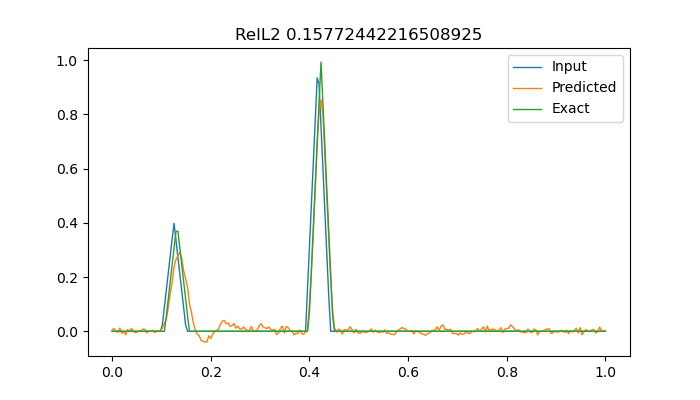

In [40]:
out = welds["tshift"][0].plot_op_predicts(0)

Explicit transcoding 0 to 1 at time 20
Explicit transcoding 1 to 2 at time 36
Explicit transcoding 0 to 1 at time 20
Explicit transcoding 1 to 2 at time 36
Explicit transcoding 0 to 1 at time 20
Explicit transcoding 1 to 2 at time 36


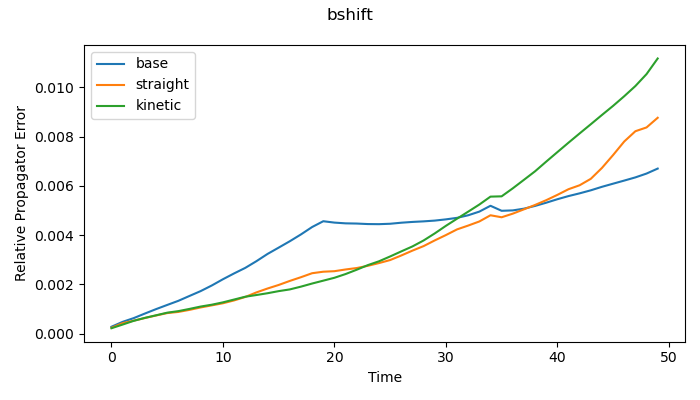

In [6]:
def compare_properrs(models, labels=None, relative=True):
  fig, ax = plt.subplots()

  for i, x in enumerate(models):
    properrs = x.get_properrs(testonly=True, relative=relative)
    ax.plot(properrs, label=x.W if labels is None else labels[i])

  ax.legend()
  ax.set_ylabel(f"{'Relative ' if relative else ''}Propagator Error")
  ax.set_xlabel("Time")

  fig.tight_layout()
  return fig

for name in names[:1]:
  vec = welds[name]
  figbase = compare_properrs(vec, labels=["base", "straight", "kinetic"])
  figbase.suptitle(name)
  figbase.tight_layout()

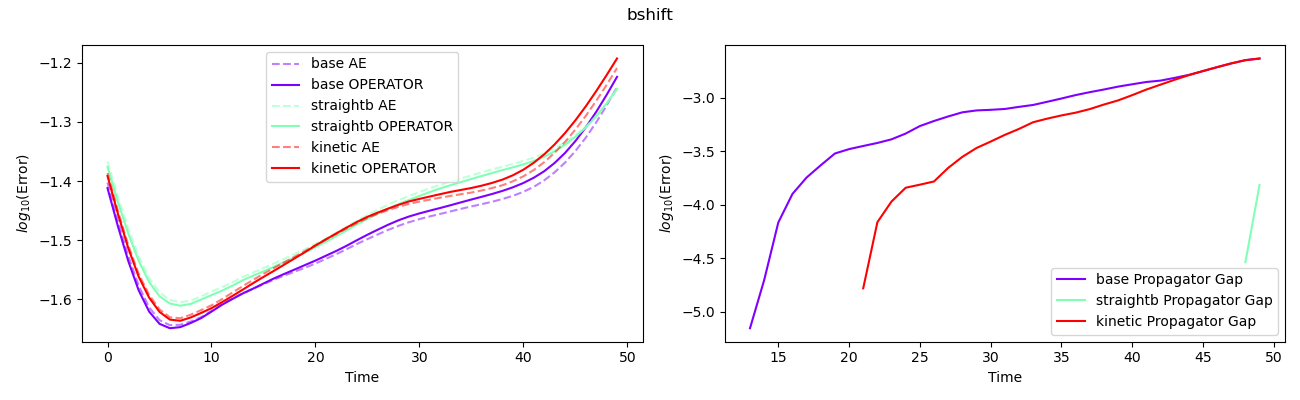

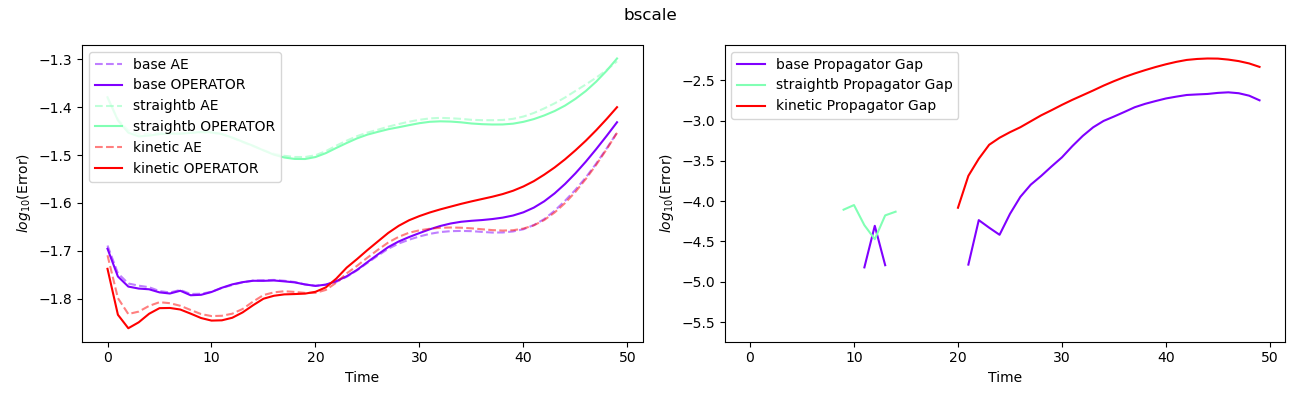

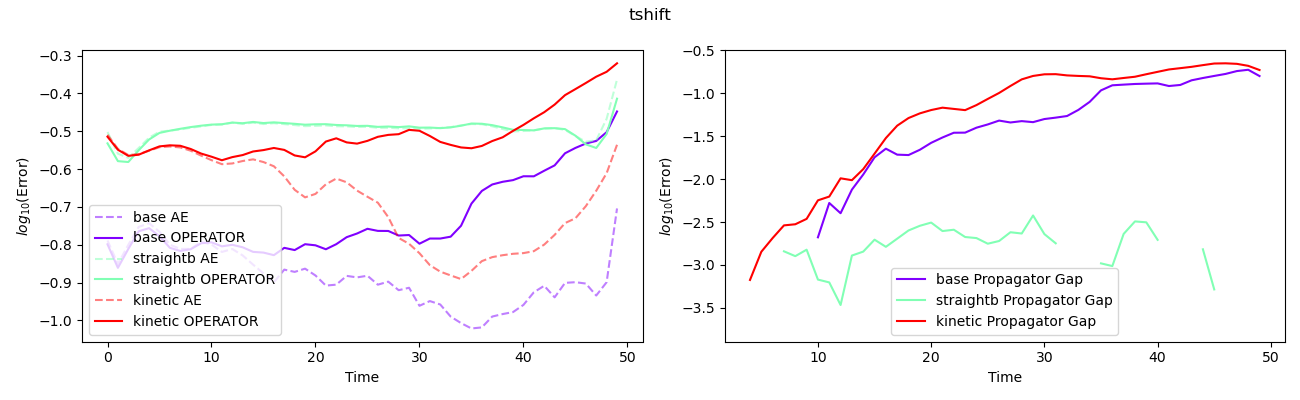

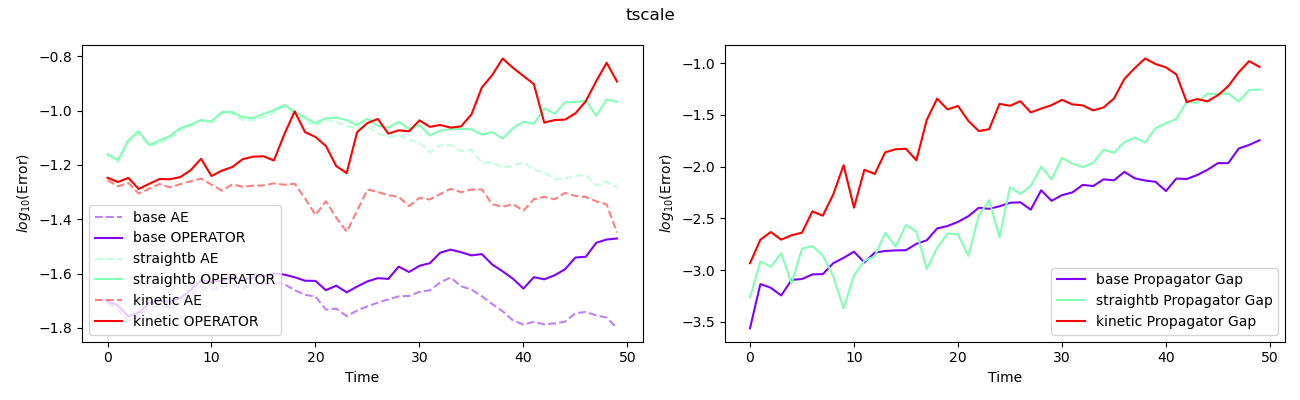

In [42]:
def compare_projop_operrs(models, labels=None, relative=True, title=None, ylims=None, difference=False):
  if difference:
    fig, axes = plt.subplots(1, 2, figsize=(13, 4))
    ax = axes[0]
    axdiff = axes[1]
  else:
    fig, ax = plt.subplots(figsize=(7, 4))
    axdiff = ax

  colors = plt.cm.rainbow(np.linspace(0, 1, len(models)))

  for i, x in enumerate(models):
    projerrs = np.asarray(x.get_projerr_times(testonly=True, relative=relative)[1:])
    operrs = np.asarray(x.get_operrs(testonly=True))

    if difference:
      axdiff.plot(np.log10(operrs - projerrs), label=f"{x.W if labels is None else labels[i]} Propagator Gap", c=colors[i])
    
    ax.plot(np.log10(projerrs), "--", label=f"{x.W if labels is None else labels[i]} AE", c=colors[i], alpha=0.5)
    ax.plot(np.log10(operrs), label=f"{x.W if labels is None else labels[i]} OPERATOR", c=colors[i])

  axdiff.legend()
  ax.legend()

  ax.set_ylabel("$log_{10}$(Error)")
  ax.set_xlabel("Time")

  axdiff.set_ylabel("$log_{10}$(Error)")
  axdiff.set_xlabel("Time")

  if ylims:
    ax.set_ylim(ylims)

  if title:
    fig.suptitle(title)

  fig.tight_layout()
  return fig

labels = ["base", "straightb", "kinetic"]
for name in names[:4]:
  vec = welds[name]
  figbase = compare_projop_operrs(vec, labels=labels, difference=True)
  figbase.suptitle(name)
  figbase.tight_layout()

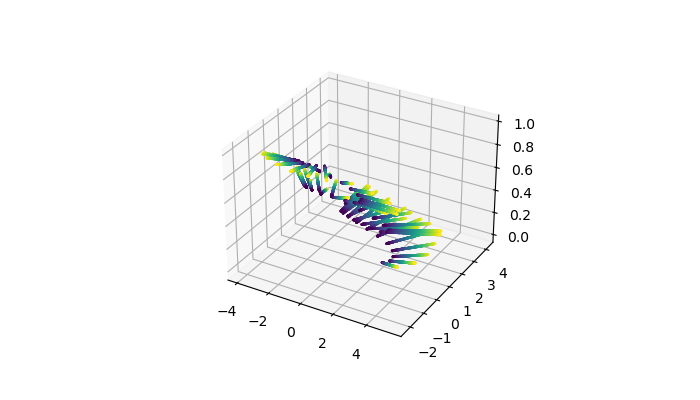

In [44]:
welds["tscale"][0].plot_encoding_all(1)

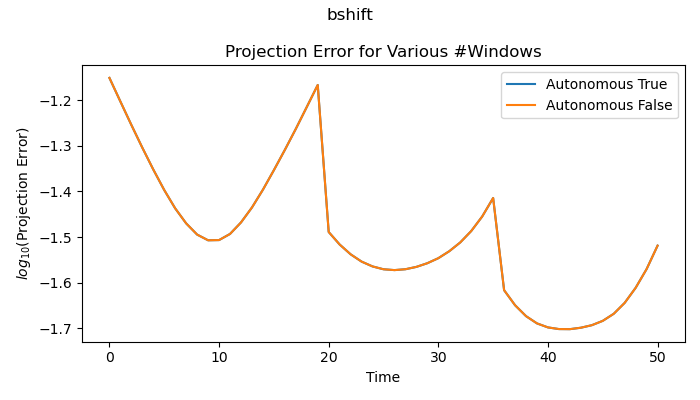

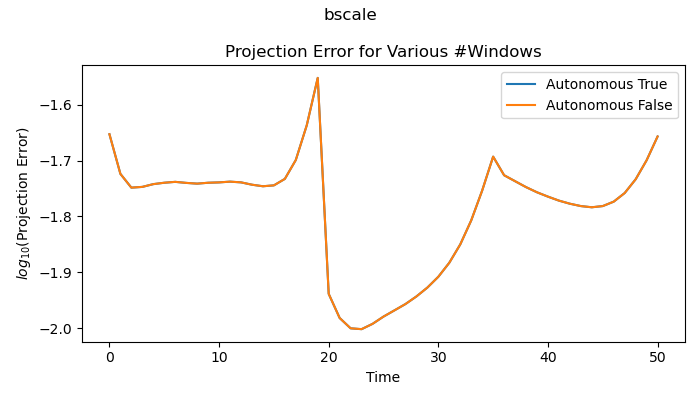

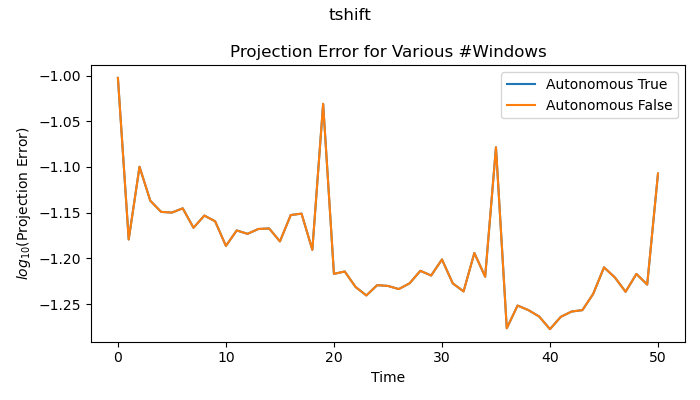

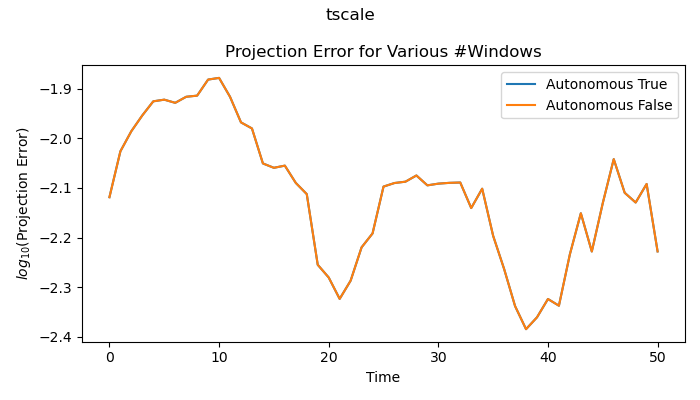

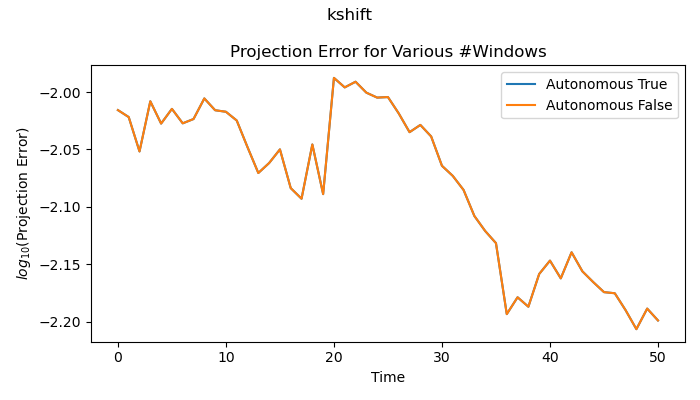

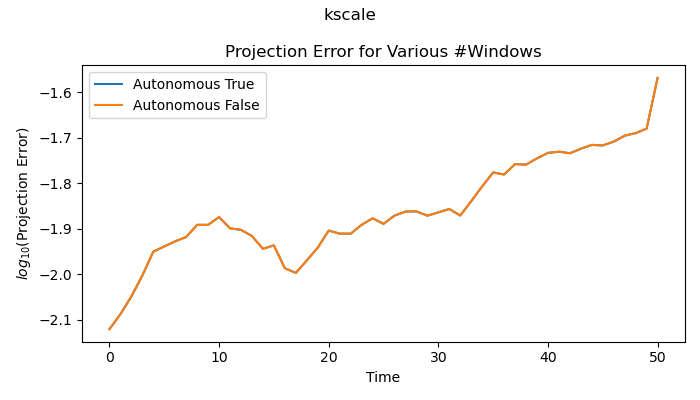

In [25]:
def compare_projerrs(models, labels=None, relative=True):
  fig, ax = plt.subplots()

  for i, x in enumerate(models):
    properrs = x.get_projerr_times(testonly=True, relative=relative)
    ax.plot(np.log10(properrs), label=x.W if labels is None else labels[i])

  ax.legend()
  ax.set_title("Projection Error for Various #Windows")
  ax.set_ylabel("$log_{10}$(Projection Error)")
  ax.set_xlabel("Time")

  fig.tight_layout()
  return fig

for name in names:
  vec = welds[name]
  figbase = compare_projerrs(vec, labels=[f"Autonomous {x.autonomous}" for x in vec])
  #figbase = compare_projop_operrs(vec, labels=[f"Autonomous {x.autonomous}" for x in vec], difference=True)
  figbase.suptitle(name)
  figbase.tight_layout()

Transcoding 0 to 1 at time 20
Transcoding 1 to 2 at time 36
(500,)
Transcoding 0 to 1 at time 20
Transcoding 1 to 2 at time 36
(500,)


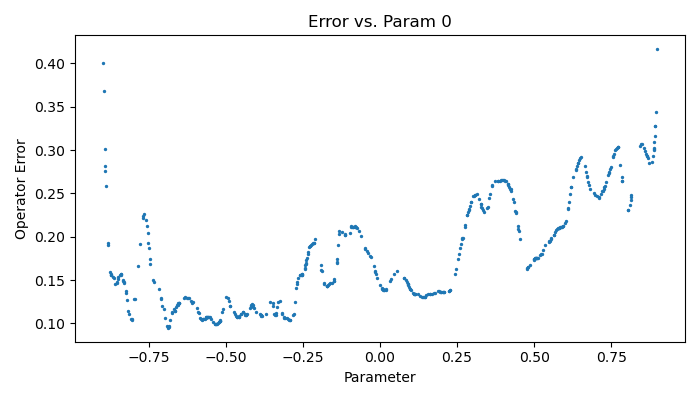

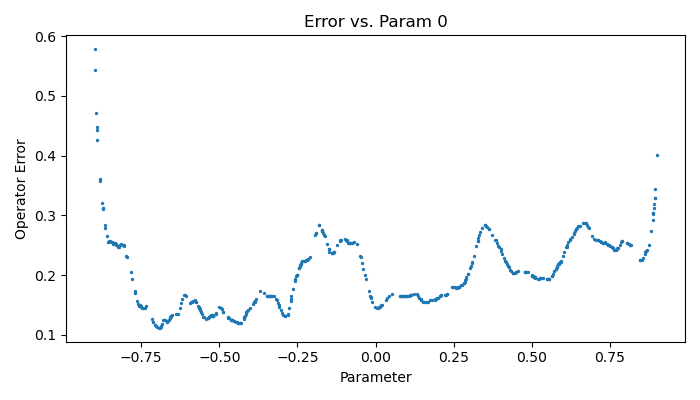

In [53]:
def plot_errorparams(weld, param=-1):
  if param == -1:
    param = determine_params(weld.dataset.params)[0]

  op = weld.get_operrs(fullerror=True)
  l2error = np.linalg.norm(np.asarray(op), axis=0)

  print(l2error.shape)

  fig, ax = plt.subplots()
  ax.scatter(weld.dataset.params[:, param], l2error, s=2)
  ax.set_xlabel("Parameter")
  ax.set_ylabel("Operator Error")
  ax.set_title(f"Error vs. Param {param}")

  fig.tight_layout()


plot_errorparams(weldbase[0])
plot_errorparams(weldbase[1])

Transcoding 0 to 1 at time 20
Transcoding 1 to 2 at time 36
Transcoding 0 to 1 at time 20
Transcoding 1 to 2 at time 36


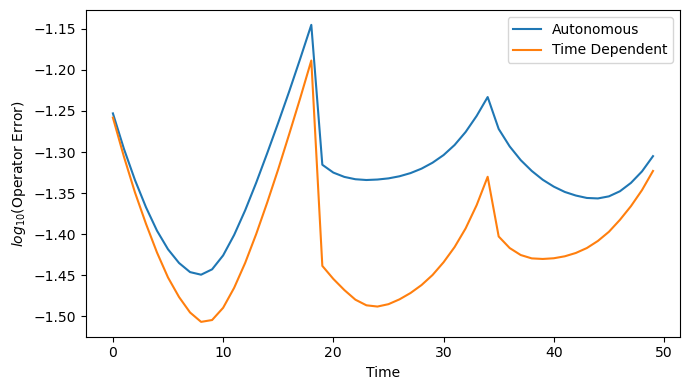

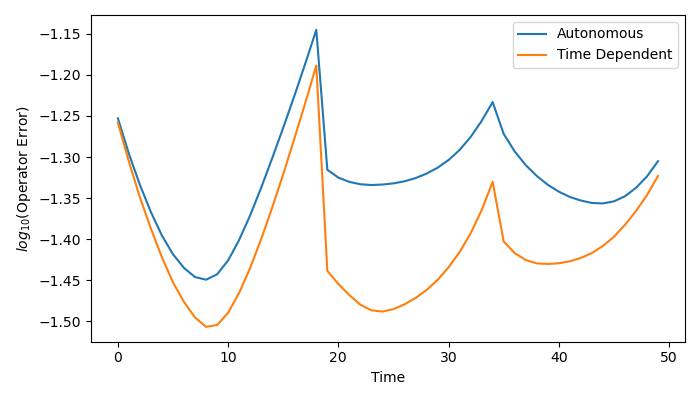

In [18]:
def compare_operrs(models, labels=None):
  fig, ax = plt.subplots()

  for i, x in enumerate(models):
    properrs = x.get_operrs(testonly=True)
    ax.plot(np.log10(properrs), label=x.W if labels is None else labels[i])

  ax.legend()
  #ax.set_title("Operator Error")
  ax.set_ylabel("$log_{10}$(Operator Error)")
  ax.set_xlabel("Time")

  fig.tight_layout()
  return fig

compare_operrs([x["base"][0] for x in welds.values()], ["Autonomous", "Time Dependent"])
#compare_projerrs(weldkinetic, [3,4,5])
#compare_operrs(welds[3]["kinetic"][1:])
#compare_projerrs(welds[3]["straight"][1:])

In [21]:
#weld = welds[0]
#weld = [x["base"][0] for x in welds.values()][0]

utils.num_params(weld.aes[0])

O(500^2) = 250,000
256 - 500 - 500 - 500 - 3

1263260

In [9]:
def plot_latent_trajectory(self : WeldNet, testnums, t=0, steps=-1, twodim=False, fixedcam=False):
  shapes = ["s"]
  shapesactual = ["*"]
  if steps == -1:
    steps = self.T - t - 1

  arr = torch.tensor(self.dataset.data[testnums, :, :]).to(self.device).float()
  outlist = self.propagate(arr[:, t, :], t, steps)
  actual = [self.encode_window(self.find_window(tt), arr[:, tt, :]) for tt in range(t + 1, t + steps + 1)]
  
  actualpoints = torch.stack(actual, dim=2).cpu().detach()
  points = torch.stack(outlist, dim=2).cpu().detach()
  print(points.shape)

  if points.shape[1] == 2 or twodim:
    fig, ax = plt.subplots()
  else:
    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")

  xmin = torch.min(points[:, 0, :])
  ymin = torch.min(points[:, 1, :])
  zmin = torch.min(points[:, 2, :])

  xmax = torch.max(points[:, 0, :])
  ymax = torch.max(points[:, 1, :])
  zmax = torch.max(points[:, 2, :])

  @widgets.interact(i=(0, points.shape[0]-1))
  def plot(i=0):
    ax.clear()

    if points.shape[1] == 2 or twodim:
      #sc = ax.scatter(points[i, 0, :], points[i, 1, :], marker=shapes[0], c=range(points.shape[2]), cmap="cool", s=10)
      ax.scatter(actualpoints[i, 0, :], actualpoints[i, 1, :], marker=shapesactual[0], c=range(actualpoints.shape[2]), cmap="cool", s=10)
    else:
      #sc = ax.scatter(points[i, 0, :], points[i, 1, :], points[i, 2, :], marker=shapes[0], c=range(points.shape[2]), cmap="cool", s=10)
      ax.scatter(actualpoints[i, 0, :], actualpoints[i, 1, :], actualpoints[i, 2, :], marker=shapesactual[0], c=range(actualpoints.shape[2]), cmap="cool", s=10)

    error = torch.mean(torch.abs(points[i] - actualpoints[i]))
    print(float(error))

    #fig.colorbar(sc, ax=ax)
    ax.set_title("o predicted, * exact")

    if fixedcam:
      ax.set_xlim(xmin, xmax)
      ax.set_ylim(ymin, ymax)
      ax.set_zlim(zmin, zmax)

weld = welds[3]["kinetic"][0]
plot_latent_trajectory(weld, [weld.dataset.get_from_params([0, x]) for x in np.linspace(0, 3, 20)], steps=-1, fixedcam=True)

KeyError: 3

0 50
Transcoding 0 to 1 at time 20
Transcoding 1 to 2 at time 36
Average Relative L2 Error over all times: 0.0155


interactive(children=(IntSlider(value=0, description='i', max=499), IntSlider(value=1, description='s', max=50…

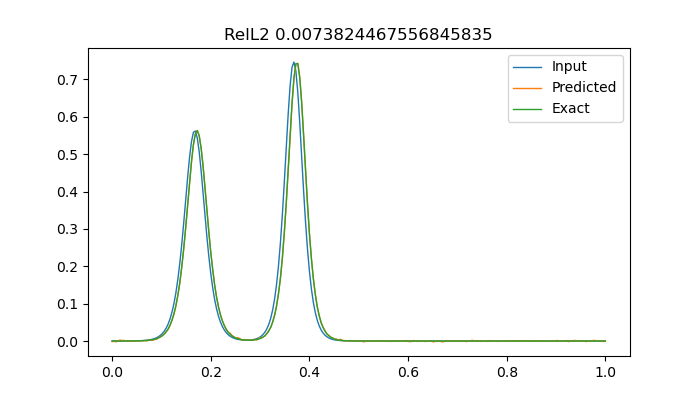

In [35]:
out = welds["kscale"][0].plot_op_predicts(0)

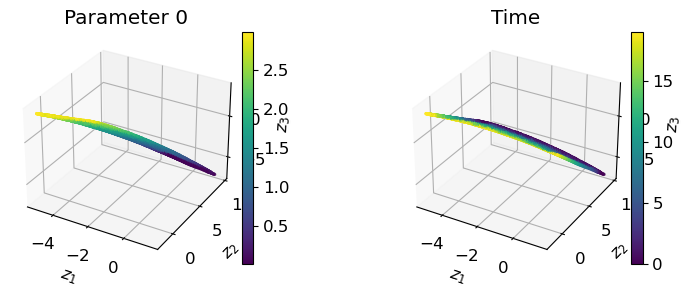

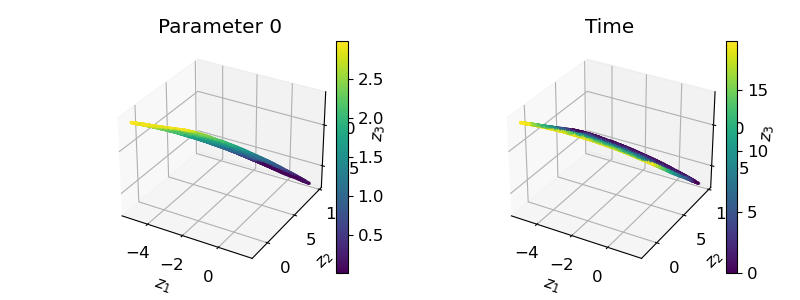

In [78]:
welds[3]["straight"][0].plot_encoding(0, 0)

In [101]:
np.max(weldbase[0].dataset.params[0, :])

2.3943979539693276